In [1]:
#import required libraries
import pandas as pd
import numpy as np
import string
import requests
from bs4 import BeautifulSoup
import quandl
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

/Users/alimalenchik/opt/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Flat file Data: Coronavirus Statistics

### Import Data

In [2]:
#read CSV
covid_df = pd.read_csv('data/full_grouped.csv',parse_dates=['Date'])
covid_df.head(n=10)

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,New cases,New deaths,New recovered,WHO Region
0,2020-01-22,Afghanistan,0,0,0,0,0,0,0,Eastern Mediterranean
1,2020-01-22,Albania,0,0,0,0,0,0,0,Europe
2,2020-01-22,Algeria,0,0,0,0,0,0,0,Africa
3,2020-01-22,Andorra,0,0,0,0,0,0,0,Europe
4,2020-01-22,Angola,0,0,0,0,0,0,0,Africa
5,2020-01-22,Antigua and Barbuda,0,0,0,0,0,0,0,Americas
6,2020-01-22,Argentina,0,0,0,0,0,0,0,Americas
7,2020-01-22,Armenia,0,0,0,0,0,0,0,Europe
8,2020-01-22,Australia,0,0,0,0,0,0,0,Western Pacific
9,2020-01-22,Austria,0,0,0,0,0,0,0,Europe


### Data Cleansing & Transformation

#### Drop/Update Columns

In [3]:
#Drop unnecessary columns
covid_df.drop(['New cases','New deaths','New recovered'], axis=1, inplace=True)

#rename columns for easier use
covid_df.rename(columns={'Country/Region':'Country',
                          'WHO Region':'WHO_Region'}, 
                 inplace=True)

#print new structure
covid_df.columns

Index(['Date', 'Country', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'WHO_Region'],
      dtype='object')

#### Fix Casing & Inconsistent Values

In [4]:
#remove punctuation in Country column for easier joining later
covid_df['Country.Clean'] = covid_df['Country'].str.replace('[{}]'.format(string.punctuation), '')

#update Country column to lower case for easier joining later
covid_df['Country.Clean'] = covid_df['Country.Clean'].str.lower()

#strip left & right spaces from Country column
covid_df['Country.Clean'] = covid_df['Country.Clean'].str.strip()

#display updated records
covid_df[['Country.Clean','Country']]

,Country.Clean,Country
0,afghanistan,Afghanistan
1,albania,Albania
2,algeria,Algeria
3,andorra,Andorra
4,angola,Angola
...,...,...
35151,west bank and gaza,West Bank and Gaza
35152,western sahara,Western Sahara
35153,yemen,Yemen
35154,zambia,Zambia


#### Find Missing Values

In [5]:
#get count of missing values
total_missing = covid_df.isnull().sum().sum()

print('There are', total_missing, 'missing values in the data frame.')

#get missing value count for each column
covid_df.isnull().sum()

There are 0 missing values in the data frame.


Date             0
Country          0
Confirmed        0
Deaths           0
Recovered        0
Active           0
WHO_Region       0
Country.Clean    0
dtype: int64

#### Find Duplicates

In [6]:
#check for duplicates at the row level
row_dupes = covid_df[covid_df.duplicated()]

#get count
dupe_cnt = len(row_dupes)

print('There are', dupe_cnt, 'row level duplicates.')

There are 0 row level duplicates.


In [7]:
#record count by country/region
country_counts = covid_df.groupby(['Country.Clean']).size().reset_index(name='record_count')
num_countries = int(country_counts['record_count'].describe()['count'])
print('There are', num_countries, 'distinct countries/regions in the data.')

#find duplicates on country/region
country_dupes = covid_df[covid_df.duplicated(['Country.Clean'])]
dupe_cnt = len(country_dupes)
print('There are', dupe_cnt, 'duplicates on Country/Region.')

country_counts

There are 187 distinct countries/regions in the data.
There are 34969 duplicates on Country/Region.


,Country.Clean,record_count
0,afghanistan,188
1,albania,188
2,algeria,188
3,andorra,188
4,angola,188
...,...,...
182,west bank and gaza,188
183,western sahara,188
184,yemen,188
185,zambia,188


In [8]:
#record count by date
date_counts = covid_df.groupby(['Date']).size().reset_index(name='record_count')
num_date = int(date_counts['record_count'].describe()['count'])
print('There are', num_date, 'distinct dates in the data.')

date_counts

There are 188 distinct dates in the data.


,Date,record_count
0,2020-01-22,187
1,2020-01-23,187
2,2020-01-24,187
3,2020-01-25,187
4,2020-01-26,187
...,...,...
183,2020-07-23,187
184,2020-07-24,187
185,2020-07-25,187
186,2020-07-26,187


#### De-Dupe Dates

In [9]:
#determine min & max date
mindate = covid_df['Date'].min()
maxdate = covid_df['Date'].max()

print('The earliest recorded date is', mindate)
print('The most recent recorded date is', maxdate)

The earliest recorded date is 2020-01-22 00:00:00
The most recent recorded date is 2020-07-27 00:00:00


In [10]:
#de-dupe to only the most recent record for each Country
covid_df = covid_df.loc[covid_df.groupby('Country.Clean').Date.idxmax()]

covid_df

,Date,Country,Confirmed,Deaths,Recovered,Active,WHO_Region,Country.Clean
34969,2020-07-27,Afghanistan,36263,1269,25198,9796,Eastern Mediterranean,afghanistan
34970,2020-07-27,Albania,4880,144,2745,1991,Europe,albania
34971,2020-07-27,Algeria,27973,1163,18837,7973,Africa,algeria
34972,2020-07-27,Andorra,907,52,803,52,Europe,andorra
34973,2020-07-27,Angola,950,41,242,667,Africa,angola
...,...,...,...,...,...,...,...,...
35151,2020-07-27,West Bank and Gaza,10621,78,3752,6791,Eastern Mediterranean,west bank and gaza
35152,2020-07-27,Western Sahara,10,1,8,1,Africa,western sahara
35153,2020-07-27,Yemen,1691,483,833,375,Eastern Mediterranean,yemen
35154,2020-07-27,Zambia,4552,140,2815,1597,Africa,zambia


#### Replace Country Column

In [11]:
#drop original Country column
covid_df.drop(['Country'], axis=1, inplace=True)

#rename clean Country column
covid_df.rename(columns={'Country.Clean':'Country'}, inplace=True)

covid_df.columns

Index(['Date', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'WHO_Region',
       'Country'],
      dtype='object')

#### Derive New Columns

In [12]:
#add columns for percentage of confirmed cases
covid_df['Percent_Recovered'] = covid_df['Recovered'] / covid_df['Confirmed']
covid_df['Percent_Deaths'] = covid_df['Deaths'] / covid_df['Confirmed']
covid_df['Percent_Active'] = covid_df['Active'] / covid_df['Confirmed']

covid_df.head()

,Date,Confirmed,Deaths,Recovered,Active,WHO_Region,Country,Percent_Recovered,Percent_Deaths,Percent_Active
34969,2020-07-27,36263,1269,25198,9796,Eastern Mediterranean,afghanistan,0.694868,0.034994,0.270138
34970,2020-07-27,4880,144,2745,1991,Europe,albania,0.562500,0.029508,0.407992
34971,2020-07-27,27973,1163,18837,7973,Africa,algeria,0.673399,0.041576,0.285025
34972,2020-07-27,907,52,803,52,Europe,andorra,0.885336,0.057332,0.057332
34973,2020-07-27,950,41,242,667,Africa,angola,0.254737,0.043158,0.702105


#### Identify outliers

In [13]:
#get IQR for each column
Q1 = covid_df.quantile(0.25)
Q3 = covid_df.quantile(0.75)
IQR = Q3 - Q1

print('IQR for each column:')
print(IQR)

IQR for each column:
Confirmed            39346.500000
Deaths                 715.500000
Recovered            21979.500000
Active                9007.500000
Percent_Recovered        0.381145
Percent_Deaths           0.029320
Percent_Active           0.374086
dtype: float64


In [14]:
#Get outlier cutoffs for each column
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

print('Lower bounds for outliers:')
print(low)

print('\nUpper bounds for outliers:')
print(high)

Lower bounds for outliers:
Confirmed           -57905.750000
Deaths               -1054.750000
Recovered           -32342.750000
Active              -13369.750000
Percent_Recovered       -0.084017
Percent_Deaths          -0.034560
Percent_Active          -0.454346
dtype: float64

Upper bounds for outliers:
Confirmed            99480.250000
Deaths                1807.250000
Recovered            55575.250000
Active               22660.250000
Percent_Recovered        1.440561
Percent_Deaths           0.082722
Percent_Active           1.041997
dtype: float64


In [15]:
#get outlier counts for Confirmed Cases
outliers_conf = covid_df[covid_df['Confirmed'] > high.Confirmed]
outliers_conf_cnt = len(outliers_conf)
print('There are', outliers_conf_cnt, 'outliers for the Confirmed column.')
outliers_conf.head()

There are 24 outliers for the Confirmed column.


,Date,Confirmed,Deaths,Recovered,Active,WHO_Region,Country,Percent_Recovered,Percent_Deaths,Percent_Active
34975,2020-07-27,167416,3059,72575,91782,Americas,argentina,0.433501,0.018272,0.548227
34982,2020-07-27,226225,2965,125683,97577,South-East Asia,bangladesh,0.555566,0.013106,0.431327
34992,2020-07-27,2442375,87618,1846641,508116,Americas,brazil,0.756084,0.035874,0.208042
35001,2020-07-27,116458,8944,0,107514,Americas,canada,0.000000,0.076800,0.923200
35004,2020-07-27,347923,9187,319954,18782,Americas,chile,0.919612,0.026405,0.053983


In [16]:
#get outlier counts for Deaths
outliers_death = covid_df[covid_df['Deaths'] > high.Deaths]
outliers_death_cnt = len(outliers_death)
print('There are', outliers_death_cnt, 'outliers for the Deaths column.')
outliers_death.head()

There are 33 outliers for the Deaths column.


,Date,Confirmed,Deaths,Recovered,Active,WHO_Region,Country,Percent_Recovered,Percent_Deaths,Percent_Active
34975,2020-07-27,167416,3059,72575,91782,Americas,argentina,0.433501,0.018272,0.548227
34982,2020-07-27,226225,2965,125683,97577,South-East Asia,bangladesh,0.555566,0.013106,0.431327
34985,2020-07-27,66428,9822,17452,39154,Europe,belgium,0.262721,0.147859,0.589420
34989,2020-07-27,71181,2647,21478,47056,Americas,bolivia,0.301738,0.037187,0.661075
34992,2020-07-27,2442375,87618,1846641,508116,Americas,brazil,0.756084,0.035874,0.208042


In [17]:
#get outlier counts for Recovered Cases
outliers_rec = covid_df[covid_df['Recovered'] > high.Recovered]
outliers_rec_cnt = len(outliers_rec)
print('There are', outliers_rec_cnt, 'outliers for the Recovered column.')
outliers_rec.head()

There are 25 outliers for the Recovered column.


,Date,Confirmed,Deaths,Recovered,Active,WHO_Region,Country,Percent_Recovered,Percent_Deaths,Percent_Active
34975,2020-07-27,167416,3059,72575,91782,Americas,argentina,0.433501,0.018272,0.548227
34982,2020-07-27,226225,2965,125683,97577,South-East Asia,bangladesh,0.555566,0.013106,0.431327
34984,2020-07-27,67251,538,60492,6221,Europe,belarus,0.899496,0.008000,0.092504
34992,2020-07-27,2442375,87618,1846641,508116,Americas,brazil,0.756084,0.035874,0.208042
35004,2020-07-27,347923,9187,319954,18782,Americas,chile,0.919612,0.026405,0.053983


In [18]:
#get outlier counts for Active Cases
outliers_act = covid_df[covid_df['Active'] > high.Active]
outliers_act_cnt = len(outliers_act)
print('There are', outliers_act_cnt, 'outliers for the Active column.')
outliers_act.head()

There are 32 outliers for the Active column.


,Date,Confirmed,Deaths,Recovered,Active,WHO_Region,Country,Percent_Recovered,Percent_Deaths,Percent_Active
34975,2020-07-27,167416,3059,72575,91782,Americas,argentina,0.433501,0.018272,0.548227
34982,2020-07-27,226225,2965,125683,97577,South-East Asia,bangladesh,0.555566,0.013106,0.431327
34985,2020-07-27,66428,9822,17452,39154,Europe,belgium,0.262721,0.147859,0.589420
34989,2020-07-27,71181,2647,21478,47056,Americas,bolivia,0.301738,0.037187,0.661075
34992,2020-07-27,2442375,87618,1846641,508116,Americas,brazil,0.756084,0.035874,0.208042


In [19]:
#get outlier counts for Percent Recovered
outliers_pct_rec = covid_df[covid_df['Percent_Recovered'] > high.Percent_Recovered]
outliers_pct_rec_cnt = len(outliers_pct_rec)
print('There are', outliers_pct_rec_cnt, 'outliers for the Percent Recovered column.')
outliers_pct_rec.head()

There are 0 outliers for the Percent Recovered column.


,Date,Confirmed,Deaths,Recovered,Active,WHO_Region,Country,Percent_Recovered,Percent_Deaths,Percent_Active


In [20]:
#get outlier counts for Percent Deaths
outliers_pct_death = covid_df[covid_df['Percent_Deaths'] > high.Percent_Deaths]
outliers_pct_death_cnt = len(outliers_pct_death)
print('There are', outliers_pct_death_cnt, 'outliers for the Percent Deaths column.')
outliers_pct_death.head()

There are 10 outliers for the Percent Deaths column.


,Date,Confirmed,Deaths,Recovered,Active,WHO_Region,Country,Percent_Recovered,Percent_Deaths,Percent_Active
34985,2020-07-27,66428,9822,17452,39154,Europe,belgium,0.262721,0.147859,0.589420
35030,2020-07-27,220352,30212,81212,108928,Europe,france,0.368556,0.137108,0.494336
35046,2020-07-27,4448,596,3329,523,Europe,hungary,0.748426,0.133993,0.117581
35054,2020-07-27,246286,35112,198593,12581,Europe,italy,0.806351,0.142566,0.051083
35080,2020-07-27,395489,44022,303810,47657,Americas,mexico,0.768188,0.111310,0.120501


In [21]:
#get outlier counts for Percent Active
outliers_pct_act = covid_df[covid_df['Percent_Active'] > high.Percent_Active]
outliers_pct_act_cnt = len(outliers_pct_act)
print('There are', outliers_pct_act_cnt, 'outliers for the Percent Active column.')
outliers_pct_act.head()

There are 0 outliers for the Percent Active column.


,Date,Confirmed,Deaths,Recovered,Active,WHO_Region,Country,Percent_Recovered,Percent_Deaths,Percent_Active


#### Update Index

In [22]:
#update index to Country field, keeping existing column data
covid_df = covid_df.set_index(['Country'], drop=False)

covid_df.head()

,Date,Confirmed,Deaths,Recovered,Active,WHO_Region,Country,Percent_Recovered,Percent_Deaths,Percent_Active
Country,,,,,,,,,,
afghanistan,2020-07-27,36263,1269,25198,9796,Eastern Mediterranean,afghanistan,0.694868,0.034994,0.270138
albania,2020-07-27,4880,144,2745,1991,Europe,albania,0.562500,0.029508,0.407992
algeria,2020-07-27,27973,1163,18837,7973,Africa,algeria,0.673399,0.041576,0.285025
andorra,2020-07-27,907,52,803,52,Europe,andorra,0.885336,0.057332,0.057332
angola,2020-07-27,950,41,242,667,Africa,angola,0.254737,0.043158,0.702105


## Web Data: GDP

### Import Data

In [23]:
#send request to the url
url='https://www.worldometers.info/gdp/gdp-per-capita/'
r=requests.get(url)
r.text

'\n<!DOCTYPE html><!--[if IE 8]> <html lang="en" class="ie8"> <![endif]--><!--[if IE 9]> <html lang="en" class="ie9"> <![endif]--><!--[if !IE]><!--> <html lang="en"> <!--<![endif]--> <head> <meta charset="utf-8"> <meta http-equiv="X-UA-Compatible" content="IE=edge"> <meta name="viewport" content="width=device-width, initial-scale=1"> <title>GDP per Capita - Worldometer</title><meta name="description" content="GDP per capita by country. List by GDP at PPP (Purchasing Power Parity) and by Nominal GDP. Ratio to World\'s average GDP per capita at PPP"><link rel="shortcut icon" href="/favicon/favicon.ico" type="image/x-icon"><link rel="apple-touch-icon" sizes="57x57" href="/favicon/apple-icon-57x57.png"><link rel="apple-touch-icon" sizes="60x60" href="/favicon/apple-icon-60x60.png"><link rel="apple-touch-icon" sizes="72x72" href="/favicon/apple-icon-72x72.png"><link rel="apple-touch-icon" sizes="76x76" href="/favicon/apple-icon-76x76.png"><link rel="apple-touch-icon" sizes="114x114" href="/

In [24]:
#parse data
soup=BeautifulSoup(r.text,'html.parser')
data=soup.findAll('tr')

data

[<tr> <th>#</th> <th>Country</th> <th>GDP (PPP) <br/> per capita <br/> (2017)</th> <th>GDP (nominal)<br/> per capita<br/> (2017) </th> <th>vs. World PPP <br/> GDP per capita<br/> ($17,100)</th> </tr>,
 <tr> <td>1</td> <td style="font-weight: bold; font-size:17px; text-align:left; padding-left:5px; padding-top:10px; padding-bottom:10px"><a href="/gdp/qatar-gdp/">Qatar</a></td> <td style="font-weight: bold;"> $128,647 </td> <td style="font-weight: bold;">$61,264</td> <td style="font-weight: bold;"> 752% </td></tr>,
 <tr> <td>2</td> <td style="font-weight: bold; font-size:17px; text-align:left; padding-left:5px; padding-top:10px; padding-bottom:10px"><a href="/gdp/china-macao-sar-gdp/">Macao</a></td> <td style="font-weight: bold;"> $115,367 </td> <td style="font-weight: bold;">$80,890</td> <td style="font-weight: bold;"> 675% </td></tr>,
 <tr> <td>3</td> <td style="font-weight: bold; font-size:17px; text-align:left; padding-left:5px; padding-top:10px; padding-bottom:10px"><a href="/gdp/lu

In [25]:
#get headers
headers=data[0]
col_headers=[th.getText() for th in headers.findAll('th')]
col_headers

['#',
 'Country',
 'GDP (PPP)  per capita  (2017)',
 'GDP (nominal) per capita (2017) ',
 'vs. World PPP  GDP per capita ($17,100)']

In [26]:
# data content (without headers & trailers)
data_content = data[1:]
data_content

[<tr> <td>1</td> <td style="font-weight: bold; font-size:17px; text-align:left; padding-left:5px; padding-top:10px; padding-bottom:10px"><a href="/gdp/qatar-gdp/">Qatar</a></td> <td style="font-weight: bold;"> $128,647 </td> <td style="font-weight: bold;">$61,264</td> <td style="font-weight: bold;"> 752% </td></tr>,
 <tr> <td>2</td> <td style="font-weight: bold; font-size:17px; text-align:left; padding-left:5px; padding-top:10px; padding-bottom:10px"><a href="/gdp/china-macao-sar-gdp/">Macao</a></td> <td style="font-weight: bold;"> $115,367 </td> <td style="font-weight: bold;">$80,890</td> <td style="font-weight: bold;"> 675% </td></tr>,
 <tr> <td>3</td> <td style="font-weight: bold; font-size:17px; text-align:left; padding-left:5px; padding-top:10px; padding-bottom:10px"><a href="/gdp/luxembourg-gdp/">Luxembourg</a></td> <td style="font-weight: bold;"> $107,641 </td> <td style="font-weight: bold;">$105,280</td> <td style="font-weight: bold;"> 629% </td></tr>,
 <tr> <td>4</td> <td styl

In [27]:
# create dataframe
GDP_df = [[td.getText() for td in tr.findAll('td')] for tr in data_content]
GDP_df = pd.DataFrame(GDP_df,columns=col_headers)
pd.set_option('display.max_rows', GDP_df.shape[0]+1)

GDP_df.head()

,#,Country,GDP (PPP) per capita (2017),GDP (nominal) per capita (2017),"vs. World PPP GDP per capita ($17,100)"
0,1,Qatar,"$128,647","$61,264",752%
1,2,Macao,"$115,367","$80,890",675%
2,3,Luxembourg,"$107,641","$105,280",629%
3,4,Singapore,"$94,105","$56,746",550%
4,5,Brunei,"$79,003","$28,572",462%


### Data Cleansing & Transformation

#### Update Column Names

In [28]:
#rename columns for easier use
GDP_df.rename(columns={'GDP (PPP)  per capita  (2017)':'GDP_PPP',
                         'GDP (nominal) per capita (2017) ':'GDP_Nominal',
                         'vs. World PPP  GDP per capita ($17,100)':'GDP_vs_World'}, 
                 inplace=True)

GDP_df.columns

Index(['#', 'Country', 'GDP_PPP', 'GDP_Nominal', 'GDP_vs_World'], dtype='object')

#### Remove punctuation

In [29]:
#remove punctuation from amount fields for conversion to numeric
GDP_df['GDP_PPP.Clean'] = GDP_df['GDP_PPP'].str.replace('[{}]'.format(string.punctuation), '')
GDP_df['GDP_Nominal.Clean'] = GDP_df['GDP_Nominal'].str.replace('[{}]'.format(string.punctuation), '')
GDP_df['GDP_vs_World.Clean'] = GDP_df['GDP_vs_World'].str.replace('[{}]'.format(string.punctuation), '')

GDP_df

,#,Country,GDP_PPP,GDP_Nominal,GDP_vs_World,GDP_PPP.Clean,GDP_Nominal.Clean,GDP_vs_World.Clean
0,1,Qatar,"$128,647","$61,264",752%,128647,61264,752
1,2,Macao,"$115,367","$80,890",675%,115367,80890,675
2,3,Luxembourg,"$107,641","$105,280",629%,107641,105280,629
3,4,Singapore,"$94,105","$56,746",550%,94105,56746,550
4,5,Brunei,"$79,003","$28,572",462%,79003,28572,462
5,6,Ireland,"$76,745","$69,727",449%,76745,69727,449
6,7,United Arab Emirates,"$74,035","$40,325",433%,74035,40325,433
7,8,Kuwait,"$72,096","$29,616",422%,72096,29616,422
8,9,Switzerland,"$66,307","$80,296",388%,66307,80296,388
9,10,San Marino,"$63,549","$48,495",372%,63549,48495,372


#### Missing Values

In [30]:
#Update 'NA' values to nulls
GDP_df.loc[GDP_df['GDP_PPP.Clean'].str.contains('NA'), 'GDP_PPP.Clean'] = np.NaN
GDP_df.loc[GDP_df['GDP_vs_World.Clean'].str.contains('NA'), 'GDP_vs_World.Clean'] = np.NaN

In [31]:
#get total count of null values
total_missing = GDP_df.isnull().sum().sum()
print('There are', total_missing, 'missing values in the data frame.')

#display null count by column
GDP_df.isnull().sum()

There are 10 missing values in the data frame.


#                     0
Country               0
GDP_PPP               0
GDP_Nominal           0
GDP_vs_World          0
GDP_PPP.Clean         5
GDP_Nominal.Clean     0
GDP_vs_World.Clean    5
dtype: int64

#### Update Data Types

In [32]:
#convert amount fields to numeric
GDP_df['GDP_PPP.Clean'] = pd.to_numeric(GDP_df['GDP_PPP.Clean'])
GDP_df['GDP_Nominal.Clean'] = pd.to_numeric(GDP_df['GDP_Nominal.Clean'])
GDP_df['GDP_vs_World.Clean'] = pd.to_numeric(GDP_df['GDP_vs_World.Clean'])

GDP_df.dtypes

#                      object
Country                object
GDP_PPP                object
GDP_Nominal            object
GDP_vs_World           object
GDP_PPP.Clean         float64
GDP_Nominal.Clean       int64
GDP_vs_World.Clean    float64
dtype: object

#### Drop Unnecessary Columns

In [33]:
#drop sequence number & original GDP columns since we have the clean versions
GDP_df.drop(['#', 'GDP_PPP', 'GDP_Nominal', 'GDP_vs_World'], axis=1, inplace=True)

In [34]:
#update column names
GDP_df.rename(columns={'GDP_PPP.Clean':'GDP_PPP',
                       'GDP_Nominal.Clean':'GDP_Nominal',
                       'GDP_vs_World.Clean':'GDP_vs_World'}, 
                 inplace=True)

#### Fix Casing & Inconsistent Values

In [35]:
#update country to lower case for easier joining later
GDP_df['Country'] = GDP_df['Country'].str.lower()

#remove punctuation for easier joining later
GDP_df['Country'] = GDP_df['Country'].str.replace('[{}]'.format(string.punctuation), '')

#strip left & right spaces from Country column
GDP_df['Country'] = GDP_df['Country'].str.strip()

#### Rename column for joining

In [36]:
#rename country column
GDP_df = GDP_df.rename(columns={'Country': 'Country.GDP'})

GDP_df.head()

,Country.GDP,GDP_PPP,GDP_Nominal,GDP_vs_World
0,qatar,128647.0,61264,752.0
1,macao,115367.0,80890,675.0
2,luxembourg,107641.0,105280,629.0
3,singapore,94105.0,56746,550.0
4,brunei,79003.0,28572,462.0


## API Data: World Bank World Development Indicators

### Import Data

In [37]:
#https://www.quandl.com/data/WWDI-World-Bank-World-Development-Indicators/documentation

#API key
quandl.ApiConfig.api_key = '#########' #insert API key

In [38]:
#load country codes into data frame
ISO_df = pd.read_csv('data/country_codes.csv', header=None, names=['Country', 'ISO_Code'])

#print first 10 countries/ISO codes
ISO_df.head(n=10)

,Country,ISO_Code
0,Afghanistan,AFG
1,Africa,AFR
2,Albania,ALB
3,Algeria,DZA
4,American Samoa,ASM
5,Andorra,AND
6,Angola,AGO
7,Antigua and Barbuda,ATG
8,Arab World,ARB
9,Argentina,ARG


In [39]:
#initialize list to store API data
world_data = []

#most recent available date for most indicators
WWDI_date = '2018-12-31'

#iterate through rows in country code file & pull API data for each ISO code
for row in ISO_df.itertuples(index=False):
    iso = row[1]
    country = row[0]
    
    #initialize dictionary with indicator values
    ind_dict = dict.fromkeys(['EN_POP_DNST', 'SP_POP_TOTL', 'SL_UEM_TOTL_ZS'])
    
    #for each indicator value, pull API data
    for key, value in ind_dict.items():
        try:
            #pull indicator data is available for the ISO
            data = quandl.get('WWDI/{}_{}'.format(iso, key), start_date = WWDI_date, end_date = WWDI_date)
            
            #assign value to the indicator key in the dictionary
            ind_dict['{}'.format(key)] = data.iloc[0]['Value']
            
        except: 
            #else assign null
            ind_dict['{}'.format(key)] = np.NaN
        
    #append ISO, country, & WWDI data to world data list
    world_data.append((country, iso, ind_dict['EN_POP_DNST'], ind_dict['SP_POP_TOTL'], ind_dict['SL_UEM_TOTL_ZS']))   

#convert world data list into dataframe & add column names    
WWDI_df = pd.DataFrame(world_data, columns = ['Country','ISO_Code','Population_Density','Total_Population',
                                             'Unemployment_Rate'])

#print first 10 lines of data frame
WWDI_df.head(n=10)

,Country,ISO_Code,Population_Density,Total_Population,Unemployment_Rate
0,Afghanistan,AFG,56.937760,37172386.0,11.057000
1,Africa,AFR,NaN,NaN,NaN
2,Albania,ALB,104.612263,2866376.0,12.340000
3,Algeria,DZA,17.730075,42228429.0,11.882000
4,American Samoa,ASM,277.325000,55465.0,NaN
5,Andorra,AND,163.842553,77006.0,NaN
6,Angola,AGO,24.713052,30809762.0,7.019000
7,Antigua and Barbuda,ATG,218.831818,96286.0,NaN
8,Arab World,ARB,37.372365,419790588.0,10.563344
9,Argentina,ARG,16.258510,44494502.0,9.220000


In [40]:
WWDI_df.describe()

,Population_Density,Total_Population,Unemployment_Rate
count,234.000000,2.410000e+02,215.000000
mean,312.946103,2.115877e+08,7.046859
std,1527.465496,8.256989e+08,5.064005
min,0.136497,1.150800e+04,0.110000
25%,37.143092,1.321977e+06,3.800000
50%,81.817790,9.100837e+06,5.622000
75%,204.487818,3.843360e+07,9.107500
max,20777.500261,7.592887e+09,26.920000


### Data Cleansing & Transformation

#### Missing Values

In [41]:
#get total count of null values
total_missing = WWDI_df.isnull().sum().sum()
print('There are', total_missing, 'missing values in the data frame.')

#display null count by column
WWDI_df.isnull().sum()

There are 75 missing values in the data frame.


Country                0
ISO_Code               0
Population_Density    21
Total_Population      14
Unemployment_Rate     40
dtype: int64

#### Fix Casing & Inconsistent Values

In [42]:
#remove punctuation for easier joining later
WWDI_df['Country'] = WWDI_df['Country'].str.replace('[{}]'.format(string.punctuation), '')

#update country to lower case for easier joining later
WWDI_df['Country'] = WWDI_df['Country'].str.lower()

#strip left & right spaces from Country.Clean column
WWDI_df['Country'] = WWDI_df['Country'].str.strip()

WWDI_df.head()

,Country,ISO_Code,Population_Density,Total_Population,Unemployment_Rate
0,afghanistan,AFG,56.937760,37172386.0,11.057
1,africa,AFR,NaN,NaN,NaN
2,albania,ALB,104.612263,2866376.0,12.340
3,algeria,DZA,17.730075,42228429.0,11.882
4,american samoa,ASM,277.325000,55465.0,NaN


#### Find Duplicates

In [43]:
#record count by country/region
country_counts = WWDI_df.groupby(['Country']).size().reset_index(name='record_count')
num_countries = int(country_counts['record_count'].describe()['count'])
print('There are', num_countries, 'distinct countries/regions in the data.')

#find duplicates on country/region
country_dupes = WWDI_df[WWDI_df.duplicated(['Country'])]
dupe_cnt = len(country_dupes)
print('There are', dupe_cnt, 'duplicates on Country/Region.')

country_dupes.head()

There are 255 distinct countries/regions in the data.
There are 0 duplicates on Country/Region.


,Country,ISO_Code,Population_Density,Total_Population,Unemployment_Rate


#### Outliers

In [44]:
#get IQR for each column
Q1 = WWDI_df.quantile(0.25)
Q3 = WWDI_df.quantile(0.75)
IQR = Q3 - Q1

print('IQR for each column:')
print(IQR)

IQR for each column:
Population_Density    1.673447e+02
Total_Population      3.711162e+07
Unemployment_Rate     5.307500e+00
dtype: float64


In [45]:
#Get outlier cutoffs for each column
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

print('Lower bounds for outliers:')
print(low)

print('\nUpper bounds for outliers:')
print(high)

Lower bounds for outliers:
Population_Density   -2.138740e+02
Total_Population     -5.434546e+07
Unemployment_Rate    -4.161250e+00
dtype: float64

Upper bounds for outliers:
Population_Density    4.555049e+02
Total_Population      9.410103e+07
Unemployment_Rate     1.706875e+01
dtype: float64


In [46]:
#get outlier counts for Population Density
outliers_pop_dens = WWDI_df[WWDI_df['Population_Density'] > high.Population_Density]
outliers_rec_cnt = len(outliers_pop_dens)
print('There are', outliers_rec_cnt, 'outliers for the Population Density column.')
outliers_pop_dens

There are 18 outliers for the Population Density column.


,Country,ISO_Code,Population_Density,Total_Population,Unemployment_Rate
11,aruba,ABW,588.027778,105845.0,NaN
16,bahrain,BHR,2017.273700,1569439.0,0.650000
17,bangladesh,BGD,1239.579312,161356039.0,4.281000
18,barbados,BRB,666.606977,286641.0,9.385000
23,bermuda,BMU,1184.685164,63973.0,NaN
41,channel islands,CHI,861.106094,170499.0,7.410000
98,hong kong sar china,HKG,7096.190476,7451000.0,2.903000
116,korea rep,KOR,529.358501,51606633.0,3.848000
126,lebanon,LBN,669.494135,6848925.0,6.143000
136,macao sar china,MAC,20777.500261,631636.0,1.966000


In [47]:
#get outlier counts for Total Population
outliers_pop_tot = WWDI_df[WWDI_df['Total_Population'] > high.Total_Population]
outliers_rec_cnt = len(outliers_pop_tot)
print('There are', outliers_rec_cnt, 'outliers for the Total Population column.')
outliers_pop_tot

There are 39 outliers for the Total Population column.


,Country,ISO_Code,Population_Density,Total_Population,Unemployment_Rate
8,arab world,ARB,37.372365,4.197906e+08,10.563344
17,bangladesh,BGD,1239.579312,1.613560e+08,4.281000
28,brazil,BRA,25.061716,2.094693e+08,12.334000
43,china,CHN,148.348833,1.392730e+09,4.276000
59,east asia pacific all income levels,EAS,95.428211,2.328138e+09,3.788435
60,east asia pacific developing only,EAP,130.810431,2.081652e+09,3.852769
63,egypt arab rep,EGY,98.873469,9.842360e+07,11.592000
68,ethiopia,ETH,109.224559,1.092246e+08,2.075000
69,euro area,EMU,127.610276,3.418582e+08,8.187791
70,europe central asia all income levels,ECS,33.466998,9.179738e+08,6.903899


In [48]:
#get outlier counts for Unemployment Rate
outliers_unempl = WWDI_df[WWDI_df['Unemployment_Rate'] > high.Unemployment_Rate]
outliers_rec_cnt = len(outliers_unempl)
print('There are', outliers_rec_cnt, 'outliers for the Unemployment Rate column.')
outliers_unempl

There are 14 outliers for the Unemployment Rate column.


,Country,ISO_Code,Population_Density,Total_Population,Unemployment_Rate
10,armenia,ARM,103.680225,2951776.0,17.496000
26,bosnia and herzegovina,BIH,64.920488,3323929.0,18.400000
27,botswana,BWA,3.977425,2254126.0,17.353001
79,gabon,GAB,8.224764,2119275.0,19.806999
84,greece,GRC,83.256214,10731726.0,19.292000
127,lesotho,LSO,69.437813,2108132.0,23.971001
129,libya,LBY,3.795632,6678567.0,18.468000
137,macedonia fyr,MKD,82.591515,2082958.0,20.736000
160,namibia,NAM,2.973746,2448255.0,19.877001
205,south africa,ZAF,47.630120,57779622.0,26.920000


#### Rename column for joining

In [49]:
WWDI_df = WWDI_df.rename(columns={'Country': 'Country.ISO'})

## Fuzzy Matching

### ISO Data

In [50]:
# add column for fuzzy matching w/ ISO data
covid_df['Country.ISO']=covid_df.Country.apply(lambda x : [process.extract(x, WWDI_df['Country.ISO'], limit=1)][0][0][0])

In [51]:
#observe differences in Country vs fuzzy match value
covid_df[covid_df['Country.ISO'] != covid_df['Country']]

,Date,Confirmed,Deaths,Recovered,Active,WHO_Region,Country,Percent_Recovered,Percent_Deaths,Percent_Active,Country.ISO
Country,,,,,,,,,,,
bahamas,2020-07-27,382,11,91,280,Americas,bahamas,0.238220,0.028796,0.732984,bahamas the
brunei,2020-07-27,141,3,138,0,Western Pacific,brunei,0.978723,0.021277,0.000000,brunei darussalam
burma,2020-07-27,350,6,292,52,South-East Asia,burma,0.834286,0.017143,0.148571,bermuda
congo brazzaville,2020-07-27,3200,54,829,2317,Africa,congo brazzaville,0.259062,0.016875,0.724063,congo rep
congo kinshasa,2020-07-27,8844,208,5700,2936,Africa,congo kinshasa,0.644505,0.023519,0.331976,congo rep
czechia,2020-07-27,15516,373,11428,3715,Europe,czechia,0.736530,0.024040,0.239430,chad
egypt,2020-07-27,92482,4652,34838,52992,Eastern Mediterranean,egypt,0.376700,0.050302,0.572998,egypt arab rep
eswatini,2020-07-27,2316,34,1025,1257,Africa,eswatini,0.442573,0.014680,0.542746,india
gambia,2020-07-27,326,8,66,252,Africa,gambia,0.202454,0.024540,0.773006,gambia the


In [52]:
#update incorrect ISO fuzzy matches with the best match
correct_fuzzy_iso = {
    "burma": "myanmar",
    "czechia": "czech republic",
    "eswatini": "south africa",
    "holy see": "italy",
    "kyrgyzstan": "europe & central asia all income levels",
    "laos": "south asia",
    "north macedonia": "macedonia fyr",
    "slovakia": "european union",
    "south korea": "korea dem rep",
    "taiwan": "china",
    "us": "united states",
    "western sahara": "north africa"
}

for key,value in correct_fuzzy_iso.items():
    covid_df.at['{}'.format(key),'Country.ISO']= '{}'.format(value)


In [53]:
#observe updated differences in Country vs fuzzy match value
covid_df[covid_df['Country.ISO'] != covid_df['Country']]

,Date,Confirmed,Deaths,Recovered,Active,WHO_Region,Country,Percent_Recovered,Percent_Deaths,Percent_Active,Country.ISO
Country,,,,,,,,,,,
bahamas,2020-07-27,382,11,91,280,Americas,bahamas,0.238220,0.028796,0.732984,bahamas the
brunei,2020-07-27,141,3,138,0,Western Pacific,brunei,0.978723,0.021277,0.000000,brunei darussalam
burma,2020-07-27,350,6,292,52,South-East Asia,burma,0.834286,0.017143,0.148571,myanmar
congo brazzaville,2020-07-27,3200,54,829,2317,Africa,congo brazzaville,0.259062,0.016875,0.724063,congo rep
congo kinshasa,2020-07-27,8844,208,5700,2936,Africa,congo kinshasa,0.644505,0.023519,0.331976,congo rep
czechia,2020-07-27,15516,373,11428,3715,Europe,czechia,0.736530,0.024040,0.239430,czech republic
egypt,2020-07-27,92482,4652,34838,52992,Eastern Mediterranean,egypt,0.376700,0.050302,0.572998,egypt arab rep
eswatini,2020-07-27,2316,34,1025,1257,Africa,eswatini,0.442573,0.014680,0.542746,south africa
gambia,2020-07-27,326,8,66,252,Africa,gambia,0.202454,0.024540,0.773006,gambia the


### GDP Data

In [54]:
# add column for fuzzy matching w/ GDP data
covid_df['Country.GDP']=covid_df.Country.apply(lambda x : [process.extract(x, GDP_df['Country.GDP'], limit=1)][0][0][0])




In [55]:
#update incorrect ISO fuzzy matches with the best match
correct_fuzzy_gdp = {
    "burma" : "myanmar",
    "djibouti" : "ethiopia",
    "eritrea" : "ethiopia",
    "holy see" : "italy",
    "greenland" : "denmark",
    "kosovo" : "serbia",
    "liechtenstein" : "germany",
    "monaco" : "",
    "somalia" : "ethiopia",
    "syria" : "",
    "taiwan" : "china",
    "us" : "united states",
    "venezuela" : "",
    "west bank and gaza" : "state of palestine",
    "western sahara" : ""
}

for key,value in correct_fuzzy_gdp.items():
    covid_df.at['{}'.format(key),'Country.GDP']= '{}'.format(value)


In [56]:
#observe differences in Country vs fuzzy match value
covid_df[covid_df['Country.GDP'] != covid_df['Country']]

,Date,Confirmed,Deaths,Recovered,Active,WHO_Region,Country,Percent_Recovered,Percent_Deaths,Percent_Active,Country.ISO,Country.GDP
Country,,,,,,,,,,,,
burma,2020-07-27,350,6,292,52,South-East Asia,burma,0.834286,0.017143,0.148571,myanmar,myanmar
congo brazzaville,2020-07-27,3200,54,829,2317,Africa,congo brazzaville,0.259062,0.016875,0.724063,congo rep,congo
congo kinshasa,2020-07-27,8844,208,5700,2936,Africa,congo kinshasa,0.644505,0.023519,0.331976,congo rep,congo
cote divoire,2020-07-27,15655,96,10361,5198,Africa,cote divoire,0.661833,0.006132,0.332034,cote divoire,côte divoire
czechia,2020-07-27,15516,373,11428,3715,Europe,czechia,0.736530,0.024040,0.239430,czech republic,czech republic czechia
djibouti,2020-07-27,5059,58,4977,24,Eastern Mediterranean,djibouti,0.983791,0.011465,0.004744,djibouti,ethiopia
eritrea,2020-07-27,265,0,191,74,Africa,eritrea,0.720755,0.000000,0.279245,eritrea,ethiopia
greenland,2020-07-27,14,0,13,1,Europe,greenland,0.928571,0.000000,0.071429,greenland,denmark
holy see,2020-07-27,12,0,12,0,Europe,holy see,1.000000,0.000000,0.000000,italy,italy


# Merge the Data Frames

In [57]:
#merge covid data with WWDI data
merge_df = covid_df.merge(WWDI_df, on='Country.ISO', how='left')

#merge covid/WWDI data with GDP data
merge_df = merge_df.merge(GDP_df, on='Country.GDP', how='left')

#view results
merge_df.head()

,Date,Confirmed,Deaths,Recovered,Active,WHO_Region,Country,Percent_Recovered,Percent_Deaths,Percent_Active,Country.ISO,Country.GDP,ISO_Code,Population_Density,Total_Population,Unemployment_Rate,GDP_PPP,GDP_Nominal,GDP_vs_World
0,2020-07-27,36263,1269,25198,9796,Eastern Mediterranean,afghanistan,0.694868,0.034994,0.270138,afghanistan,afghanistan,AFG,56.937760,37172386.0,11.057,1976.0,538.0,12.0
1,2020-07-27,4880,144,2745,1991,Europe,albania,0.562500,0.029508,0.407992,albania,albania,ALB,104.612263,2866376.0,12.340,12943.0,4521.0,76.0
2,2020-07-27,27973,1163,18837,7973,Africa,algeria,0.673399,0.041576,0.285025,algeria,algeria,DZA,17.730075,42228429.0,11.882,15293.0,4048.0,89.0
3,2020-07-27,907,52,803,52,Europe,andorra,0.885336,0.057332,0.057332,andorra,andorra,AND,163.842553,77006.0,NaN,NaN,39128.0,NaN
4,2020-07-27,950,41,242,667,Africa,angola,0.254737,0.043158,0.702105,angola,angola,AGO,24.713052,30809762.0,7.019,6658.0,4096.0,39.0


In [58]:
#Drop redundant columns
merge_df.drop(['Country.GDP','Country.ISO'], axis=1, inplace=True)
print(merge_df.columns)

Index(['Date', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'WHO_Region',
       'Country', 'Percent_Recovered', 'Percent_Deaths', 'Percent_Active',
       'ISO_Code', 'Population_Density', 'Total_Population',
       'Unemployment_Rate', 'GDP_PPP', 'GDP_Nominal', 'GDP_vs_World'],
      dtype='object')


### Load Merged Data into Database

In [59]:
#setting a SQLite connection in memory
cnx = sqlite3.connect(':memory:')

#save df to cnx:
merge_df.to_sql(name='COVID', con=cnx)

#retrieve via read_sql
tbl = pd.read_sql('select * from COVID', cnx)
tbl

,index,Date,Confirmed,Deaths,Recovered,Active,WHO_Region,Country,Percent_Recovered,Percent_Deaths,Percent_Active,ISO_Code,Population_Density,Total_Population,Unemployment_Rate,GDP_PPP,GDP_Nominal,GDP_vs_World
0,0,2020-07-27 00:00:00,36263,1269,25198,9796,Eastern Mediterranean,afghanistan,0.694868,0.034994,0.270138,AFG,56.937760,3.717239e+07,11.057000,1976.0,538.0,12.0
1,1,2020-07-27 00:00:00,4880,144,2745,1991,Europe,albania,0.562500,0.029508,0.407992,ALB,104.612263,2.866376e+06,12.340000,12943.0,4521.0,76.0
2,2,2020-07-27 00:00:00,27973,1163,18837,7973,Africa,algeria,0.673399,0.041576,0.285025,DZA,17.730075,4.222843e+07,11.882000,15293.0,4048.0,89.0
3,3,2020-07-27 00:00:00,907,52,803,52,Europe,andorra,0.885336,0.057332,0.057332,AND,163.842553,7.700600e+04,NaN,NaN,39128.0,NaN
4,4,2020-07-27 00:00:00,950,41,242,667,Africa,angola,0.254737,0.043158,0.702105,AGO,24.713052,3.080976e+07,7.019000,6658.0,4096.0,39.0
5,5,2020-07-27 00:00:00,86,3,65,18,Americas,antigua and barbuda,0.755814,0.034884,0.209302,ATG,218.831818,9.628600e+04,NaN,23522.0,15825.0,138.0
6,6,2020-07-27 00:00:00,167416,3059,72575,91782,Americas,argentina,0.433501,0.018272,0.548227,ARG,16.258510,4.449450e+07,9.220000,20829.0,14508.0,122.0
7,7,2020-07-27 00:00:00,37390,711,26665,10014,Europe,armenia,0.713159,0.019016,0.267826,ARM,103.680225,2.951776e+06,17.496000,9668.0,3918.0,57.0
8,8,2020-07-27 00:00:00,15303,167,9311,5825,Western Pacific,australia,0.608443,0.010913,0.380644,AUS,3.247871,2.498269e+07,5.298000,49378.0,53831.0,289.0
9,9,2020-07-27 00:00:00,20558,713,18246,1599,Europe,austria,0.887538,0.034682,0.077780,AUT,107.127967,8.840521e+06,4.848000,53879.0,47261.0,315.0


In [60]:
#update date datatype since it was converted to object
tbl.Date = pd.to_datetime(tbl.Date)

#view data types
tbl.dtypes

index                          int64
Date                  datetime64[ns]
Confirmed                      int64
Deaths                         int64
Recovered                      int64
Active                         int64
WHO_Region                    object
Country                       object
Percent_Recovered            float64
Percent_Deaths               float64
Percent_Active               float64
ISO_Code                      object
Population_Density           float64
Total_Population             float64
Unemployment_Rate            float64
GDP_PPP                      float64
GDP_Nominal                  float64
GDP_vs_World                 float64
dtype: object

# Visualizations

### Correlation Heatmap

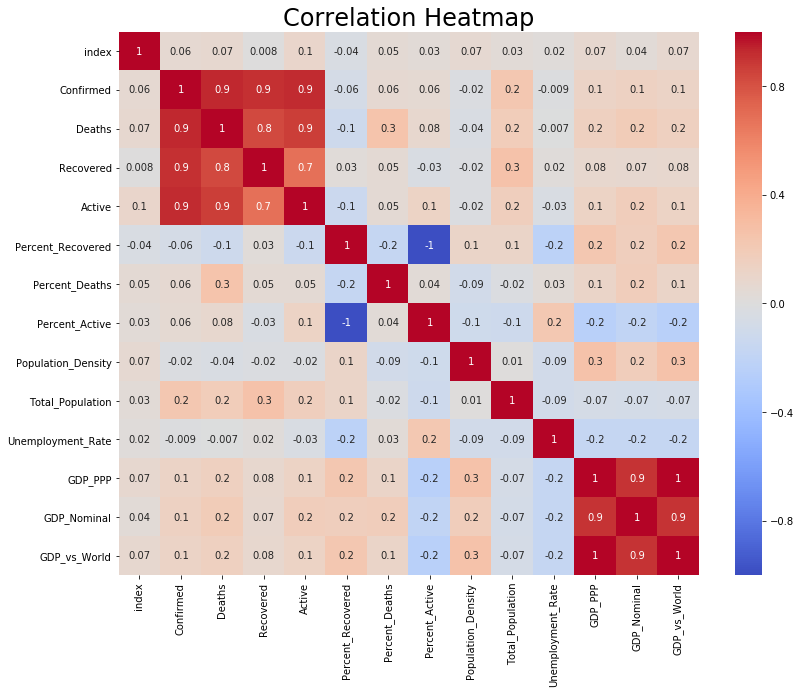

In [61]:
#adjust figure size
plt.rcParams["figure.figsize"] = (13,10)

#create correlation heatmap
ax = sns.heatmap(tbl.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

#add title
plt.title("Correlation Heatmap", fontsize=24)

#adjust limits to fix cutoff issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

#display plot
plt.show()

### Scatterplot - Covid Deaths vs. GDP_PPP

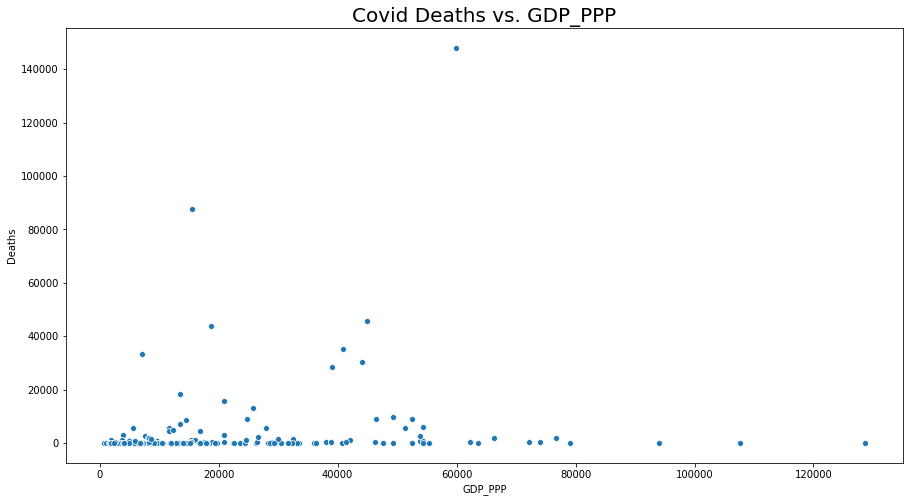

In [62]:
#update figure size
plt.rcParams["figure.figsize"] = (15,8)

#create scatterplot
sns.scatterplot(x="GDP_PPP", y="Deaths", data=tbl)

#add titles and axis labels
plt.title('Covid Deaths vs. GDP_PPP', fontsize=20)

#display scatterplot
plt.show()

### Scatterplot - Percent Recovered vs. Population Density

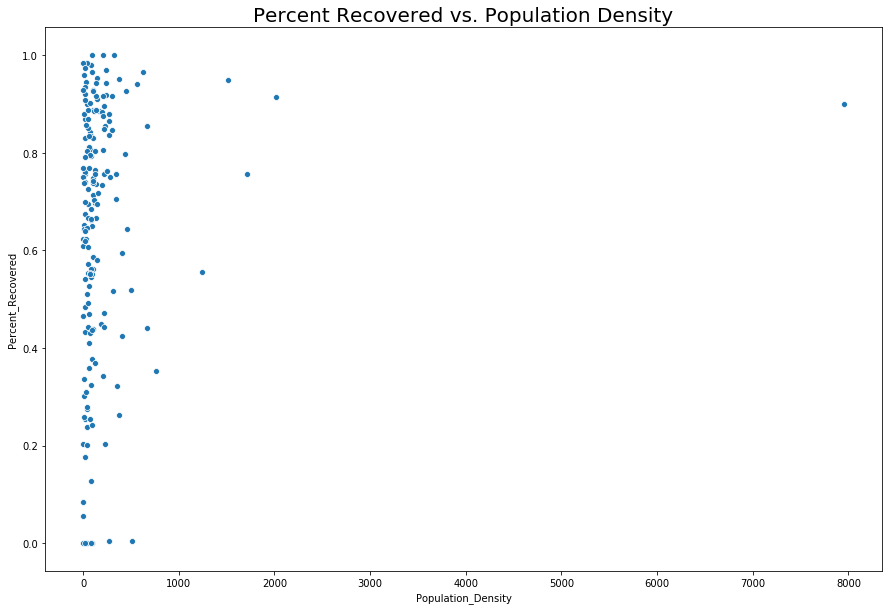

In [63]:
#update figure size
plt.rcParams["figure.figsize"] = (15,10)

#create scatterplot
sns.scatterplot(x="Population_Density", y="Percent_Recovered", data=tbl)

#add titles and axis labels
plt.title('Percent Recovered vs. Population Density', fontsize=20)

#display scatterplot
plt.show()

### Bar Plot - Sum of Confirmed Cases by WHO Region

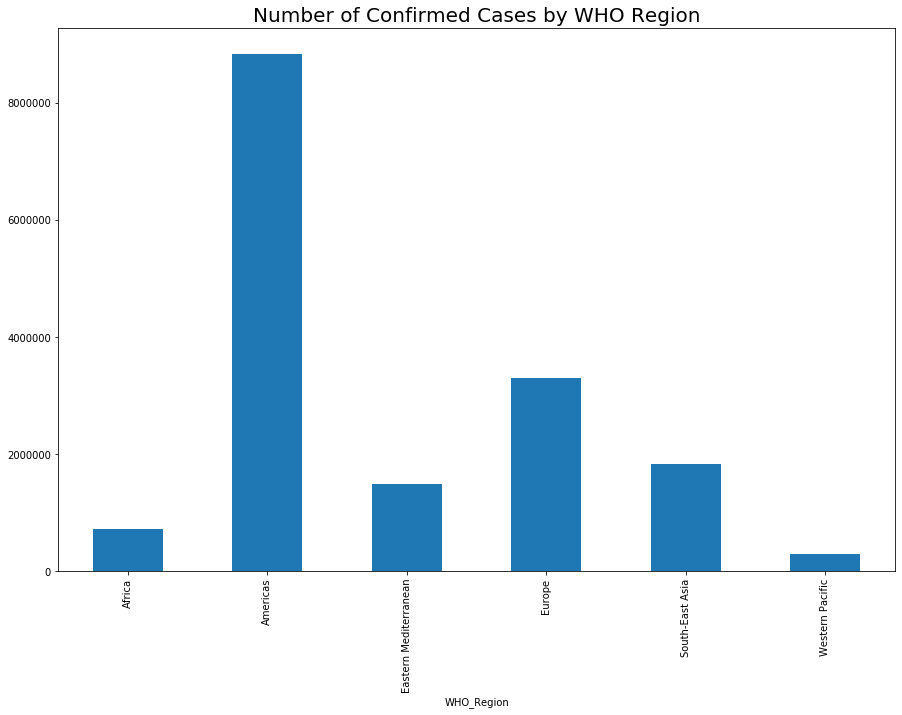

In [64]:
#group data by WHO region & get sum of confirmed cases
var = tbl.groupby('WHO_Region').Confirmed.sum() #Group sum of Sales at Gender level

#create bar plot
var.plot(kind='bar') 

#add titles and axis labels
plt.title('Number of Confirmed Cases by WHO Region', fontsize=20)

#display plot
plt.show()

### Box Plot - Deaths by WHO Region

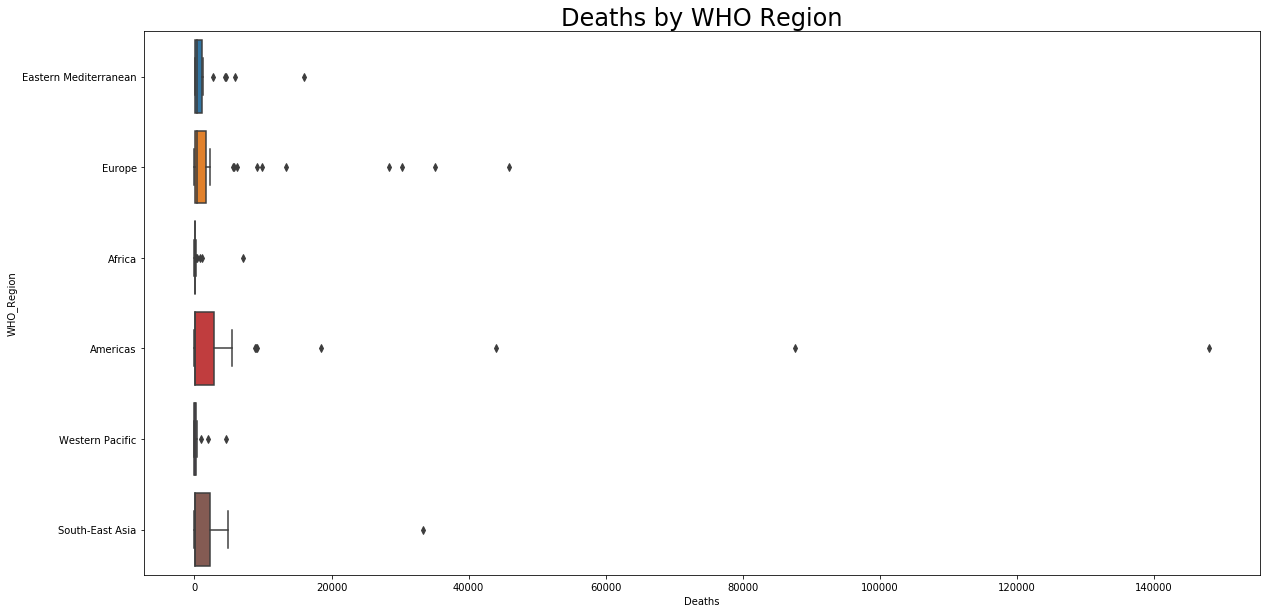

In [65]:
#change figure size
plt.rcParams["figure.figsize"] = (20,10)

#create boxplot of victim age for each racial demographic
sns.boxplot(x='Deaths', y='WHO_Region', data=covid_df)

#modify tick frequency & size
#plt.yticks(np.arange(0, 110, 10), fontsize=14)
#plt.xticks(fontsize=14)

#add title & axis labels
plt.title("Deaths by WHO Region", fontsize=24)
#plt.xlabel('Race', fontsize=18)
#plt.ylabel('Age', fontsize=18)

#display plot
plt.show()

## Summary

The most challenging part of this project was learning how best to extract the World Bank data. Because the API extracted based on ISO code and WWDI indicator, I needed some way to pass a list of ISO codes, and a list of indicators, to the API request at the same time. In this case I was able to build and update a dictionary as the API pulled the information. I am skeptical that this is the best/most efficient way to pull the data, especially since the piece of API code seems to contribute to most of the execution time.

Another part I struggled with was formatting the web data in order to align its structure with a data frame. Because csv data is already in a tabular format, and I had control of how I extracted my API data, I did not have many issues creating a data frame from those sources. Understanding how to parse the web data was a challenge to me, and I learned how to utilize beautifulsoup for this purpose.

Finally, I learned how to leverage fuzzy matching when joining datasets from multiple sources. This is another piece that I believe may not be the most efficient method, but luckily since my data frames were small prior to joining, I was able to make it work. If I were to use a larger dataset I would look for another method of fuzzy matching that works faster. I thought this was most interesting to me since I am familiar with joining data within a database, but I have never done fuzzy matching.